# Ablation Study: Window Size
In this notebook, we compare ClaP with with different window size selection algorithms.

In [14]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [15]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

from aeon.visualisation import plot_critical_difference
from external.MCM import MCM
from wand.image import Image

sns.set_theme()
sns.set_color_codes()

import os
import sys

sys.path.append("../../")

Let's choose a score for evaluation (AMI).

In [16]:
eval_score = "covering_score"

Let's load the scores from the different methods.

In [17]:
classifier = ["suss", "fft", "acf"] # , 

datasets = ["train"] 
methods, dfs = list(), list()

for candidate_name in classifier:
    methods.append((candidate_name, f"{candidate_name}.csv.gz"))

for idx, (name, file_name) in enumerate(methods):
    df = []
    
    for d in datasets:
        df.append(pd.read_csv(f"../../experiments/ablation_study/{d}_{file_name}", compression="gzip")) # usecols=["dataset", eval_score],
    
    df = pd.concat(df)
    df.sort_values(by="dataset", inplace=True)
    dfs.append((name, df))

df_scores = pd.DataFrame()

for name, df in dfs:
    df_scores["dataset"] = df.dataset
    df_scores[name] = df[eval_score]

df_scores.reset_index(drop=True, inplace=True)
df_scores

,dataset,suss,fft,acf
0,DodgerLoopDay,1.000,1.000,1.000
1,EEGRat,0.825,0.909,0.909
2,EEGRat2,0.737,0.737,0.737
3,FaceFour,0.840,0.671,0.671
4,GrandMalSeizures2,0.538,0.538,0.594
5,GreatBarbet1,0.816,0.816,0.816
6,Herring,1.000,1.000,1.000
7,InlineSkate,0.486,0.486,0.486
8,InsectEPG1,0.409,0.430,0.767
9,MelbournePedestrian,0.984,0.984,0.984


Let's calculate the mean/median/std score.

In [18]:
df_scores.iloc[:,1:].mean(axis=0).sort_values(ascending=False).round(3)

suss    0.805
acf     0.794
fft     0.777
dtype: float64

In [19]:
df_scores.iloc[:,1:].median(axis=0).sort_values(ascending=False).round(3)

suss    0.816
fft     0.789
acf     0.789
dtype: float64

In [20]:
df_scores.iloc[:,1:].std(axis=0).sort_values().round(3)

acf     0.155
suss    0.174
fft     0.181
dtype: float64

Let's compute the wins per method.

In [21]:
ranks = df_scores.iloc[:,1:].rank(1, method='min', ascending=False)
means = np.array(ranks.mean(axis=0))
args = np.argsort(means)

In [22]:
for mean, name in zip(means[args], df_scores.columns[1:].to_numpy()[args]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 1)}")

suss:wins=18 rank=1.2
fft:wins=16 rank=1.3
acf:wins=17 rank=1.3


Let's plot the CD diagram.

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4364/2105585120.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../../figures/cd_ablation_study_window_size_train.pdf", bbox_inches="tight")
/Users/ermshaua/miniconda3/envs/clap/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


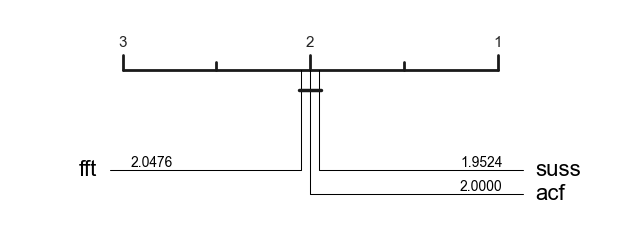

In [23]:
ax = plot_critical_difference(
    scores=df_scores.iloc[:, 1:].to_numpy(),
    labels=df_scores.columns[1:].to_numpy(),
    alpha=0.05,
)

plt.savefig("../../figures/cd_ablation_study_window_size_train.pdf", bbox_inches="tight")

Let's plot the MCM.

Processing suss, fft:   0%|          | 0/3 [00:00<?, ?it/s]/Users/ermshaua/miniconda3/envs/clap/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
Processing acf, fft:   0%|          | 0/3 [00:00<?, ?it/s] 


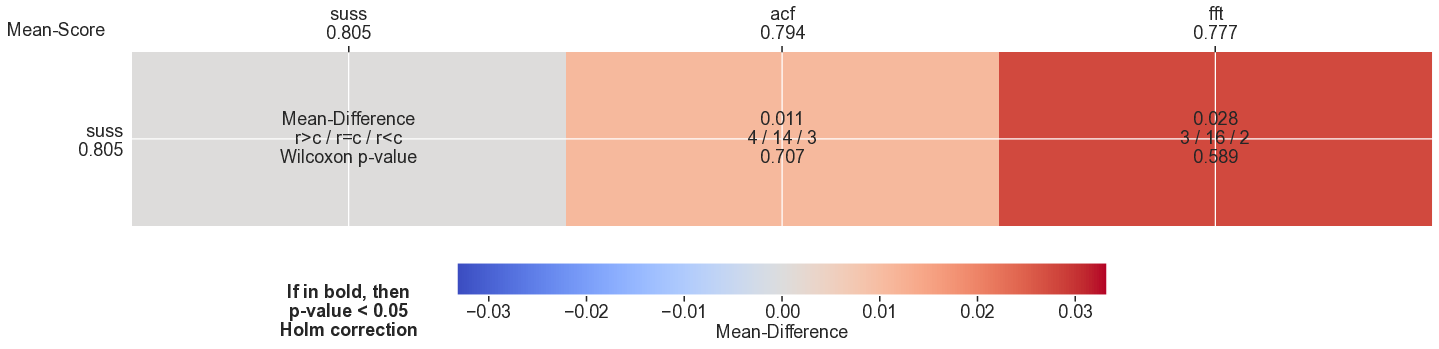

In [24]:
dir_path = "../../figures/"
file_name = "mcm_ablation_study_window_size_train"

MCM.compare(
    output_dir=dir_path,
    used_statistic="Score",
    save_as_json=False,
    df_results=df_scores.iloc[:, 1:],
    pdf_savename=file_name,
    load_analysis=False,
    pvalue_correction="Holm",
    row_comparates=("suss",),
    fig_size=(20,5),
    font_size=18,
    precision=3
)
Image(filename=os.path.join(dir_path, file_name + ".pdf"))

Let's compute wins/losses against cgain.

In [25]:
selection = "suss"

for rival in df_scores.columns[1:]:
    if rival == selection: continue

    df_pair = df_scores[[selection, rival]]
    pair_ranks = df_pair.rank(1, method='min', ascending=False)

    wins = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks[selection] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 1)].shape[0]

    assert wins + losses + ties == pair_ranks.shape[0]

    print(f"{selection} vs {rival}: (wins/ties/losses): {wins}/{ties}/{losses}")

suss vs fft: (wins/ties/losses): 3/16/2
suss vs acf: (wins/ties/losses): 4/14/3


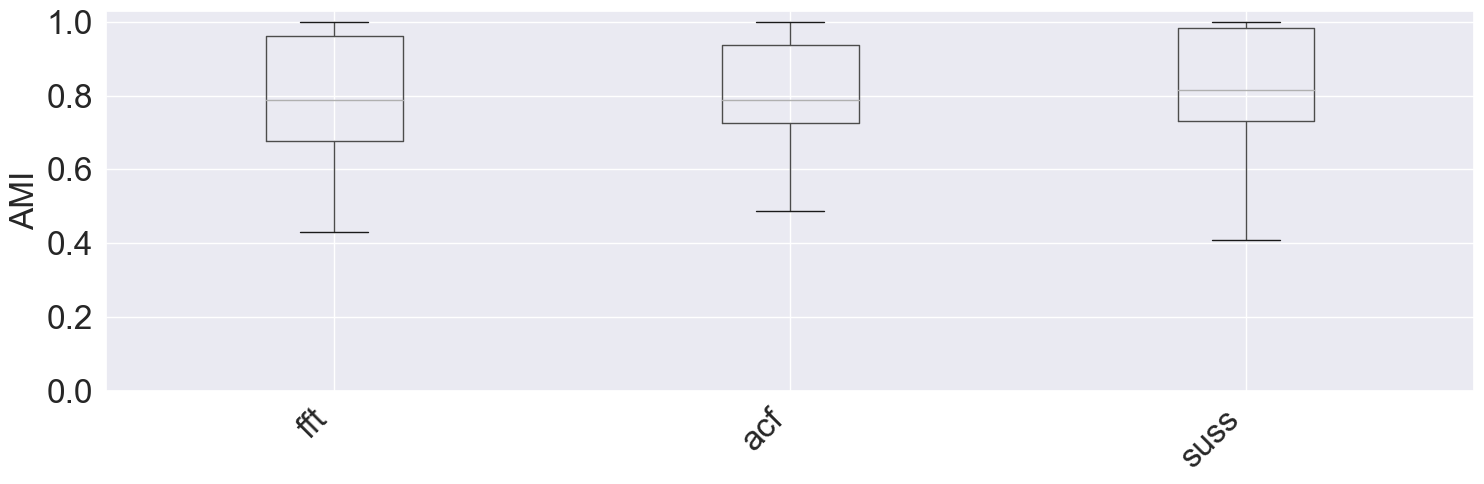

In [26]:
fontsize = 24
_, ax = plt.subplots(figsize=(15, 5))

# sort by median performance
df_sorted_scores = df_scores[df_scores.iloc[:, 1:].median(axis=0).sort_values().index]

df_sorted_scores.boxplot(ax=ax, rot=90)
ax.set_ylabel("AMI", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xticklabels(df_sorted_scores.columns, rotation=45, ha="right")
ax.set_yticks(np.round(np.arange(0, 1.0 + .2, .2), 1))

plt.savefig(f"../../figures/bp_ablation_study_window_size_train.pdf", bbox_inches="tight")